# Umap from Metadata

This notebook loads a csv and builds a Umap visualisation around one metadata column.

### Import Variables

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### Read Data

In [2]:
url = "assets/data.csv"
data = pd.read_csv(url)

### Data cleaning

Define the csv column to build the umap from and specify a character to split within the field, when needed.

In [3]:
metadata = "ecrm:P102_has_title" # ecrm:P67_refers_to
split = " | "

In [4]:
import json

selection = []

for idx, val in enumerate(data[metadata].dropna()):
    datum = val.split(split)
    icon = []
    
    for j in datum:
        icon.append(j)
                    
    if icon:
        icon= ' '.join(icon)
        selection.append(icon)


In [5]:
selectiondf = pd.DataFrame(selection, columns=["metadata"])
merged = pd.concat([data, selectiondf["metadata"]], axis = 1)

In [6]:
merged.head()

,o:id,o:media[file],dcterms:title,ecrm:P48_has_preferred_identifier,ecrm:P45_consists_of,ecrm:P54_has_current_permanent_location,ecrm:P67i_is_referred_to_by,ecrm:P108i_was_produced_by,ecrm:P140_assigned_attribute_to,ecrm:P59i_is_located_on_or_within,...,ecrm:P59_has_section,ecrm:P24i_changed_ownership_through,ecrm:P165_incorporates,ecrm:P8_took_place_on_or_within,ecrm:P138_represents,ecrm:P138i_has_representation,ecrm:P106_is_composed_of,ecrm:P3_has_note,skos:exactMatch,metadata
0,5103,https://uclab.fh-potsdam.de/refa/files/origina...,NaN,M_186_555,Öl auf Holz,NaN,NaN,1550-01-01 / 1599-12-31; Q11; Datierung Kleidu...,NaN,NaN,...,NaN,"acquisition; Lipperheide, Franz von (1838 - 19...",|,2013-10-09; Grunderfassung; Dokumentation der ...,NaN,|,NaN,Sabine de Günther; 2018-01-03 | Sabine de Günt...,NaN,Bildnis einer Frau mit spanischem Hut und Hals...
1,686,https://uclab.fh-potsdam.de/refa/files/origina...,NaN,G_017_093,Öl auf Leinwand,NaN,NaN,1675-01-01 / 1699-12-31; Q11; Datierung Kleidu...,NaN,NaN,...,NaN,"acquisition; Lipperheide, Franz von ; 1878-11-...",NaN,NaN,NaN,NaN,NaN,Sabine de Günther; 2018-07-31 | Sabine de Günt...,NaN,"Bildnis eines Herrn mit Perücke, Halskrause un..."
2,685,https://uclab.fh-potsdam.de/refa/files/origina...,NaN,G_044_118,Öl auf Leinwand,NaN,NaN,1530-01-01 / 1599-12-31; Q11; Datierung Kleidu...,NaN,NaN,...,NaN,"acquisition; Lipperheide, Franz von ; 1878-11-...",NaN,NaN,NaN,|,NaN,Sabine de Günther; 2019-12-03,NaN,Bildnis einer Frau im schwarzen Obergewand und...
3,684,https://uclab.fh-potsdam.de/refa/files/origina...,NaN,M_121_504,"rotes Metall, Kupfer (?)",NaN,NaN,1620-01-01 / 1629-12-31; Q11; Datierung Kleidu...,NaN,NaN,...,NaN,"acquisition; Lipperheide, Franz von ; 1878-11-...",NaN,2013-12-02; Grunderfassung; Dokumentation der ...,NaN,| |,NaN,Sabine de Günther; 2017-06-12 | Sabine de Günt...,NaN,Bildnis einer Frau im reich bestickten Gewand ...
4,683,https://uclab.fh-potsdam.de/refa/files/origina...,NaN,G_162_237,Öl auf Leinwand,NaN,NaN,1800-01-01 / 1824-12-31; Q11; Datierung Kleidu...,NaN,NaN,...,NaN,"acquisition; Lipperheide, Franz von ; 1878-11-...",NaN,NaN,NaN,|,NaN,Sabine de Günther; 2017-04-20 | Sabine de Günt...,NaN,Bildnis einer Frau mit rotem Federschmuck und ...


## Training

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

components = cv.fit_transform(selection)
components.shape

(606, 2688)

In [8]:
import umap.umap_ as umap

reducer = umap.UMAP(
        n_neighbors=7,
        min_dist=.4 
)

pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
embedding = pipe.fit_transform(components.toarray())

umap_positions = pd.DataFrame(embedding, columns=["x", "y"])

data_umap = pd.concat([merged, umap_positions], axis = 1)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
x_domain = [data_umap["x"].min(), data_umap["x"].max() ]
y_domain = [data_umap["y"].min(), data_umap["y"].max() ]

### Display the cluster

In [10]:
alt.Chart(data_umap).mark_circle().encode(
    alt.X('x', scale=alt.Scale(domain=x_domain), axis=alt.Axis(labels=False)),
    alt.Y('y', scale=alt.Scale(domain=y_domain), axis=alt.Axis(labels=False)),
    tooltip="metadata"
).properties(width=400, height=400)

alt.Chart(...)

### Add images

Specify the path where to load the images

In [11]:
path = '../assets/refa/'

In [12]:
tx, ty = data_umap["x"].dropna(), data_umap["y"].dropna()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Connect the images to the csv file

In [13]:
ids = data_umap['o:id'].tolist()

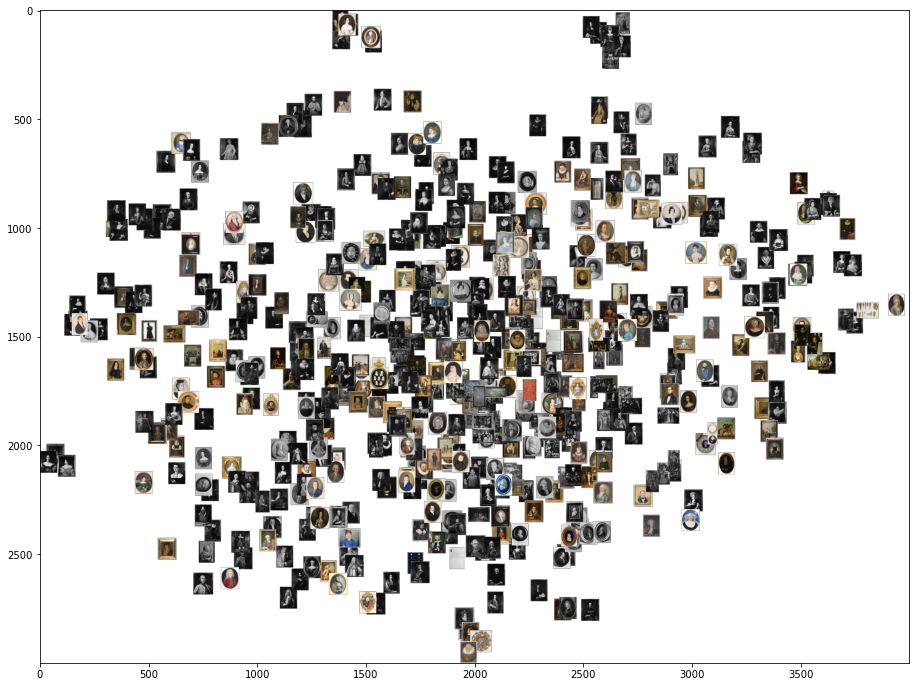

In [14]:
import matplotlib.pyplot
from PIL import Image
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))

for imgId, x, y in zip(ids, tx, ty):
    img = path + str(imgId) + ".jpg"
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

###  Export the generated csv

In [15]:
import os  
os.makedirs('../data/', exist_ok=True)  
data_umap.to_csv('../data/' + metadata.replace(":","_") + '_out.csv')  